<a href="https://colab.research.google.com/github/ditumystro/Skin-detection-with-python/blob/main/Skin-detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import cv2
import numpy as np
from numpy import array
from matplotlib import pyplot as plt
from copy import deepcopy
import os, os.path
import pickle
from pathlib import Path
import time
from time import gmtime, strftime
import pandas as pd
import seaborn as sns
import sys
from math import *
from mpl_toolkits import mplot3d
import glob

# %matplotlib notebook
%matplotlib inline

In [ ]:

#Open a simple image
img=cv2.imread("0724.jpg")

#converting from gbr to hsv color space
img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

#skin color range for hsv color space 
HSV_mask = cv2.inRange(img_HSV, (0, 15, 0), (17,170,255)) 
HSV_mask = cv2.morphologyEx(HSV_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

#converting from gbr to YCbCr color space
img_YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
#skin color range for hsv color space 
YCrCb_mask = cv2.inRange(img_YCrCb, (0, 135, 85), (255,180,135)) 
YCrCb_mask = cv2.morphologyEx(YCrCb_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

#merge skin detection (YCbCr and hsv)
global_mask=cv2.bitwise_and(YCrCb_mask,HSV_mask)
global_mask=cv2.medianBlur(global_mask,3)
global_mask = cv2.morphologyEx(global_mask, cv2.MORPH_OPEN, np.ones((4,4), np.uint8))


HSV_result = cv2.bitwise_not(HSV_mask)
YCrCb_result = cv2.bitwise_not(YCrCb_mask)
global_result=cv2.bitwise_not(global_mask)


#show results
cv2_imshow(HSV_result)
cv2_imshow(YCrCb_result)
cv2_imshow(global_result)
cv2_imshow(img)
cv2.imwrite("1_HSV.jpg",HSV_result)
cv2.imwrite("2_YCbCr.jpg",YCrCb_result)
cv2.imwrite("3_global_result.jpg",global_result)
cv2.waitKey(0)
cv2.destroyAllWindows()  

In [28]:
MIDDLE_DATA_DIR = '/middle_data'
OBJECTS = ['SKIN','NON_SKIN']
DIR_TRAIN = '/content/drive/MyDrive/Dataset8_Abdomen/train/original_images/'
DIR_TEST  = '/content/drive/MyDrive/Dataset8_Abdomen/test/original_images/'
EXT= '.jpg'
DIR_TRAIN_M = '/content/drive/MyDrive/Dataset8_Abdomen/train/skin_masks/'

SCALE = 1

HISTS = []

len(OBJECTS)
nbre_img = len([name for name in os.listdir(DIR_TRAIN) if os.path.isfile(os.path.join(DIR_TRAIN, name))])
#nbre_img /=len(OBJECTS)+1
nbre_img = int(nbre_img)
nbre_img

1200

In [ ]:
HISTS = train(CLASSES,EXT,True, False)


In [47]:
# chargement des images originales et masks

list_images = [ file for file in os.listdir(DIR_TRAIN)  if os.path.isfile(os.path.join(DIR_TRAIN,file)) ]

list_masks = [file for file in os.listdir(DIR_TRAIN_M)]

list_images.sort()
list_masks.sort()

masks = []
images_lab = []
images = []

#print(list_images[0])
#print(list_masks)

"""listd = []
for img in glob.glob(DIR_TRAIN + '*.jpg'):
  cv_img = cv2.imread(img)
  listd.append(cv_img)"""


for filename in list_images:
  img = cv2.imread(DIR_TRAIN + filename)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  images.append(img)

for f in list_masks:
	mas = cv2.imread(DIR_TRAIN_M + f)
	masks.append(mas)

images_matrice = np.array(images)
masks_matrice = np.array(masks)



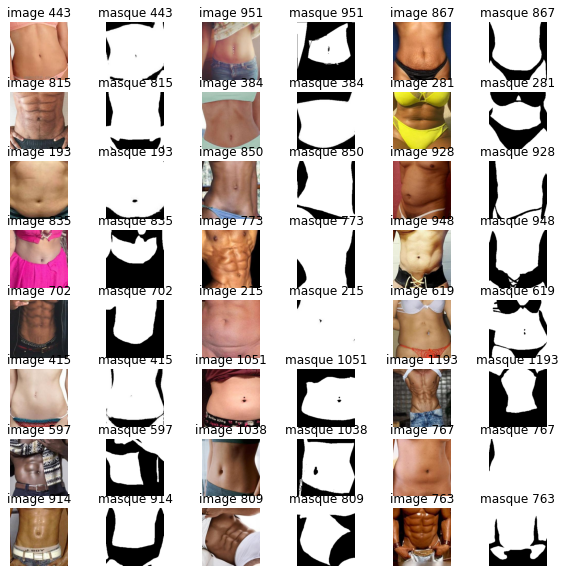

In [48]:
# affichage de certaines images et leurs masques

plt.figure(figsize=(10, 10))
for k,i in np.ndenumerate(np.random.randint(images_matrice.shape[0], size=24)):
  ax = plt.subplot(8, 6, 2*k[0] + 1)
  plt.imshow(images_matrice[i], cmap='gray')
  plt.title('image {}'.format(i))
  plt.axis("off")

  bx=plt.subplot(8, 6, 2*k[0] +2)
  plt.imshow(masks_matrice[i], cmap='gray')
  plt.title('masque {}'.format(i))
  plt.axis("off")

In [54]:
#convertion de l'espace de couleur RGB en LAB
images_lab = [0] * images_matrice.shape[0]
for i, img in enumerate(images):
  images_lab[i] = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

#Affichage de certaines images dans l'espace Lab 

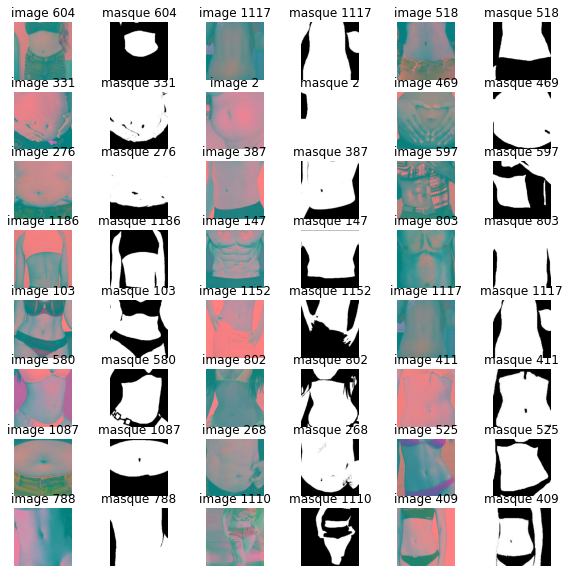

In [55]:
#affichage dequelques images dans l'espace LAB

plt.figure(figsize=(10, 10))
for k,i in np.ndenumerate(np.random.randint(images_matrice.shape[0], size=24)):
  ax = plt.subplot(8, 6, 2*k[0] + 1)
  plt.imshow(images_lab[i], cmap='gray')
  plt.title('image {}'.format(i))
  plt.axis("off")

  bx=plt.subplot(8, 6, 2*k[0] +2)
  plt.imshow(masks_matrice[i], cmap='gray')
  plt.title('masque {}'.format(i))
  plt.axis("off")


In [ ]:
# reduction de l'espace de valeurs en LAB

def reduction_space(images):
  